# **IMPORT LIBRARIES AND SET CONFIGURATION**

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import time
import h5py
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import gc
from torch.optim import AdamW
import torchvision

In [17]:
class CFG:
    train_batch_size=32
    val_batch_size=64
    nepochs=10
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    epsilon = 1e-9
    lr = 1e-4

# ***IMPORT DATA***


Only first 10000 jet images are used due to memory limits

In [3]:
f = h5py.File('/kaggle/input/quark-gluon-dataset/dataset.hdf5')
X = f['/X_jets'][:10000]
y = f['/y'][:10000]
sz = len(X)

In [4]:
%%time
X_train = X[:int(0.8*sz)]
X_val = X[int(0.8*sz):]
y_train = y[:int(0.8*0.6*sz)]
y_val = y[int(0.8*sz):]

CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 19.3 µs


In [58]:
X_train_mean =  np.mean(X_train,axis=(0,1,2),keepdims=True)
X_train_std = np.std(X_train,axis=(0,1,2),keepdims=True)

X_train_normalized = (X_train -X_train_mean)/(X_train_std)
X_val_normalized = (X_val - X_train_mean)/(X_train_std)

In [66]:
X_trainloader = DataLoader(X_train,batch_size=CFG.train_batch_size,shuffle=False)
y_trainloader = DataLoader(y_train,batch_size=CFG.train_batch_size,shuffle=False)
X_validloader = DataLoader(X_val,batch_size=CFG.val_batch_size,shuffle=False)
y_validloader = DataLoader(y_val,batch_size=CFG.val_batch_size,shuffle=False)

In [61]:
a = next(iter(X_validloader))

# Visualize Original Jet Images

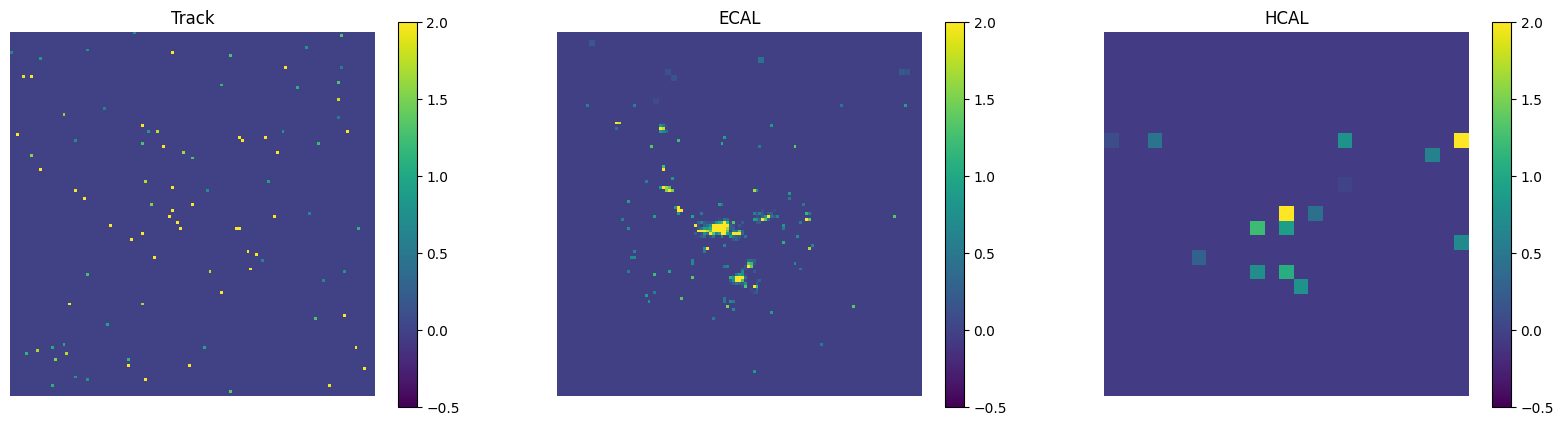

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
ls = ['Track','ECAL','HCAL']
for i in range(3):
    temp = axes[i].imshow(a[0,:,:,i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i].axis('off')
    axes[i].set_title('{}'.format(ls[i]))
    fig.colorbar(temp, ax=axes[i], shrink=0.25)

# Calculating Mean and Std if the dataset is large

In [6]:


""""psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(X_trainloader):
    psum += inputs.sum(axis=[0, 1, 2])
    psum_sq += (inputs**2).sum(axis=[0, 1, 2])
count = len(X_train)*125*125
print(psum)
print(count)
# mean and std
total_mean = psum / count
total_var = (psum_sq / count) - (total_mean**2)
total_std = torch.sqrt(total_var)

# output
print("mean: " + str(total_mean))
print("std:  " + str(total_std))
train_mean = total_mean
#train_mean = torch.tensor([0.0, 0.0, 0.0])
train_std = total_std""""
####

100%|██████████| 250/250 [00:01<00:00, 167.65it/s]


tensor([9782.8770, 6198.3008, 3898.5168])
125000000
mean: tensor([7.8263e-05, 4.9586e-05, 3.1188e-05])
std:  tensor([0.0037, 0.0020, 0.0005])


# VAE Network

In [67]:
## Encoder Module

class VAEncoder(nn.Module):
    def __init__(self):
        super(VAEncoder,self).__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=2,bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.LeakyReLU()
        self.drop1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.LeakyReLU()
        self.drop2 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.LeakyReLU()
        self.drop3 = nn.Dropout(0.25)
        """self.conv3 = nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        """
        self.conv4 = nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
    def forward(self,x):
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.relu1(x)#(16,64,64)
        #x = self.drop1(x)
        x = self.conv2(x)
        #x = self.bn2(x)
        x = self.relu2(x)#(32,32,32)
        #x = self.drop2(x)
        x = self.conv3(x)
        #x = self.bn3(x)
        x = self.relu3(x)#(64,16,16)
        #x = self.drop3(x)
        x = self.conv4(x)
        #x = self.bn4(x)
        x = self.relu4(x)#(64,8,8)##End of encoder use ReLU according to a paper
        #x = self.drop4(x)
        x = self.flatten(x)#(4096)
        return x
    
## Decoder Module
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.linear1 = nn.Linear(400,4096)
        self.deconv4 = nn.ConvTranspose2d(64,64,kernel_size=3,stride=2,padding=0,bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.LeakyReLU()
        self.deconv3 = nn.ConvTranspose2d(64,32,kernel_size=3,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.LeakyReLU()
        self.deconv2 = nn.ConvTranspose2d(32,16,kernel_size=3,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.LeakyReLU()
        self.deconv1 = nn.ConvTranspose2d(16,3,kernel_size=3,stride=2,padding=1,bias=False)
        self.relu1 = nn.ReLU()
        #self.tanh = nn.Tanh()
    def forward(self,x):
        x = self.linear1(x)
        x = x.reshape((-1,64,8,8))
        
        x = self.deconv4(x)
        #x = self.bn4(x)
        x = self.relu4(x)
        x = self.deconv3(x)
        #x = self.bn3(x)
        x = self.relu3(x)
        x = self.deconv2(x)
        #x = self.bn2(x)
        x = self.relu2(x)
        x = self.deconv1(x)
        #x = self.tanh(x)
        #x = self.relu1(x)
        return x[:,:,:125,:125]
class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder,self).__init__()
        self.encoder = VAEncoder()
        self.decoder = Decoder()
        self.z_mean = nn.Linear(4096,400)
        self.z_log_var = nn.Linear(4096,400)
    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(CFG.device)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [68]:
def early_stopping(train_loss, validation_loss, min_delta, tolerance):
    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
            return True

In [69]:
def invdiceloss(decoded,batch_x):
    batch_size = decoded.shape[0]
    """print(batch_x.shape)
    print(decoded.shape)"""
    denom = 2*(decoded*batch_x).view(batch_size,-1).sum(axis=1)+(1e-7)
    num = F.mse_loss(decoded,batch_x,reduction='none').sum(axis=(1,2,3))
    #num = num.mean()
    
    """print(num.shape)
    print(denom.shape)"""
    return (num)/denom

In [70]:
print(X_train_mean[0,0,0])
print(X_train_std[0,0,0])

[7.8265919e-05 4.9543094e-05 3.1149350e-05]
[0.00371461 0.00194817 0.00047809]


In [71]:
model = VariationalAutoEncoder()
model.to(CFG.device)
criterion = F.mse_loss
optimizer = AdamW(params=model.parameters(),lr=CFG.lr)
train_epoch_losses = []
valid_epoch_losses = []
train_batch_losses = []
valid_batch_losses = []
train_normalize = torchvision.transforms.Normalize(mean=X_train_mean[0,0,0],std=X_train_std[0,0,0])
valid_normalize = torchvision.transforms.Normalize(mean=X_train_mean[0,0,0],std=X_train_std[0,0,0])

In [72]:
#model(torch.rand((1,3,125,125),device=CFG.device))[3]

In [73]:
#CFG.nepochs=5
for epoch in range(CFG.nepochs):
    print(f"Epoch {epoch}:-")
    y_iterator = iter(y_trainloader)
    model.train()
    te_loss = []
    flag=1
    count=0
    for batch_x in tqdm(iter(X_trainloader)):
        count+=1
        optimizer.zero_grad()
        ##FORWARD PASS
        batch_x = (batch_x.permute(0,3,1,2)).to(device=CFG.device)
        batch_x_norm = train_normalize(batch_x).to(device=CFG.device)
        encoded, z_mean, z_log_var, decoded = model(batch_x_norm)
        #print(decoded)
        ##LOSS
        kl_div = -0.5 * torch.sum(1 + z_log_var - z_mean**2- torch.exp(z_log_var), axis=1)
        batchsize = kl_div.size(0)
        kl_div = kl_div.mean()
        pixelwise = criterion(decoded, batch_x_norm, reduction='none')
        #pixelwise = invdiceloss(decoded,batch_x)
        #print(pixelwise.view(batchsize,-1).sum(axis=1).shape)
        pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
        pixelwise = pixelwise.mean()
        loss = pixelwise + kl_div
        if count%1000==0 and epoch<4:
            print(f"{pixelwise} ",end = '')
        ##BACKWARD
        loss.backward()
        optimizer.step()
        te_loss.append(loss.detach().cpu().item())
        #te_loss.append(pixelwise.detach().cpu())
        #loss = loss.detach().cpu()
        train_batch_losses.append(te_loss[-1])
        batch_x.to('cpu')
        encoded.to('cpu')
        decoded.to('cpu')
        #break
    #start_time = time.time()
    del batch_x,encoded,decoded
    gc.collect()
    #print(time.time()-start_time)
    te_loss = np.array(te_loss).mean()
    train_epoch_losses.append(te_loss)
    print("Running Valid Loop")
    ve_loss = []
    
    
    model.eval()
    count=0
    for batch_x in tqdm(iter(X_validloader)):
        count+=1
        ##FORWARD PASS
        batch_x = (batch_x.permute(0,3,1,2)).to(device=CFG.device)
        batch_x_norm = train_normalize(batch_x).to(device=CFG.device)
        encoded, z_mean, z_log_var, decoded = model(batch_x_norm)
        ##LOSS
        kl_div = -0.5 * torch.sum(1 + z_log_var - z_mean**2- torch.exp(z_log_var), axis=1)
        batchsize = kl_div.size(0)
        kl_div = kl_div.mean()
        with torch.no_grad():
            pixelwise = criterion(decoded, batch_x_norm, reduction='none')
            #pixelwise = invdiceloss(decoded,batch_x)
            #print(pixelwise.view(batchsize,-1).sum(axis=1).shape)
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean()
            loss = pixelwise + kl_div
            if count%1000==0 and epoch<4:
                print(f"{pixelwise} ",end = '')
            le = loss.cpu().item()
            if le<1e7:
                ve_loss.append(le)
                valid_batch_losses.append(ve_loss[-1])
        batch_x.to('cpu')
        encoded.to('cpu')
        decoded.to('cpu')
        #batch_y.to('cpu')
        #ve_loss.append(pixelwise.detach().cpu())
        #loss = loss.detach().cpu()
        
        #break
    ve_loss = np.array(ve_loss).mean()
    valid_epoch_losses.append(ve_loss)
    del batch_x,encoded,decoded
    gc.collect()
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'state_dict')
    print(f"Training Loss:- {train_epoch_losses[-1]} Valid loss:- {valid_epoch_losses[-1]}")
    if early_stopping(train_epoch_losses[-1],valid_epoch_losses[-1],1e-5,5):
        print(f'Training Reached Early Stop at {epoch}')
        break
    

Epoch 0:-


100%|██████████| 250/250 [00:34<00:00,  7.35it/s]


Running Valid Loop


100%|██████████| 32/32 [00:03<00:00,  9.74it/s]


Training Loss:- 42619.9281875 Valid loss:- 58825.66979980469
Epoch 1:-


100%|██████████| 250/250 [00:32<00:00,  7.66it/s]


Running Valid Loop


100%|██████████| 32/32 [00:03<00:00,  9.99it/s]


Training Loss:- 35937.79946875 Valid loss:- 56409.028564453125
Epoch 2:-


100%|██████████| 250/250 [00:32<00:00,  7.60it/s]


Running Valid Loop


100%|██████████| 32/32 [00:03<00:00,  9.65it/s]


Training Loss:- 35400.664515625 Valid loss:- 56126.855041503906
Epoch 3:-


100%|██████████| 250/250 [00:32<00:00,  7.58it/s]


Running Valid Loop


100%|██████████| 32/32 [00:03<00:00,  9.86it/s]


Training Loss:- 35263.8794765625 Valid loss:- 51691.87153477823
Epoch 4:-


100%|██████████| 250/250 [00:33<00:00,  7.56it/s]


Running Valid Loop


100%|██████████| 32/32 [00:03<00:00,  9.57it/s]


Training Loss:- 35106.9087265625 Valid loss:- 87993.25164794922
Epoch 5:-


100%|██████████| 250/250 [00:33<00:00,  7.57it/s]


Running Valid Loop


100%|██████████| 32/32 [00:03<00:00, 10.18it/s]


Training Loss:- 35067.6583515625 Valid loss:- 55637.249084472656
Epoch 6:-


100%|██████████| 250/250 [00:33<00:00,  7.42it/s]


Running Valid Loop


100%|██████████| 32/32 [00:03<00:00,  9.95it/s]


Training Loss:- 34989.038359375 Valid loss:- 55556.564025878906
Epoch 7:-


100%|██████████| 250/250 [00:32<00:00,  7.59it/s]


Running Valid Loop


100%|██████████| 32/32 [00:03<00:00,  9.85it/s]


Training Loss:- 34906.07665625 Valid loss:- 55423.36511230469
Epoch 8:-


100%|██████████| 250/250 [00:34<00:00,  7.33it/s]


Running Valid Loop


100%|██████████| 32/32 [00:03<00:00,  9.75it/s]


Training Loss:- 34788.070125 Valid loss:- 55208.87365722656
Epoch 9:-


100%|██████████| 250/250 [00:32<00:00,  7.59it/s]


Running Valid Loop


100%|██████████| 32/32 [00:03<00:00,  9.96it/s]


Training Loss:- 34652.7876796875 Valid loss:- 55062.625549316406


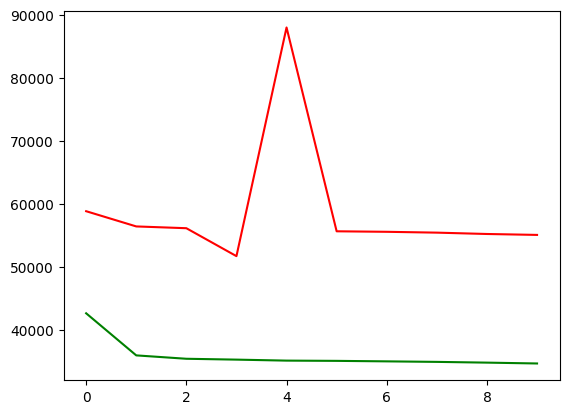

In [74]:
plt.plot(train_epoch_losses,c='g',label='training loss')
plt.plot(valid_epoch_losses,c='r',label='validation loss')
#plt.ylim([34000,100000])

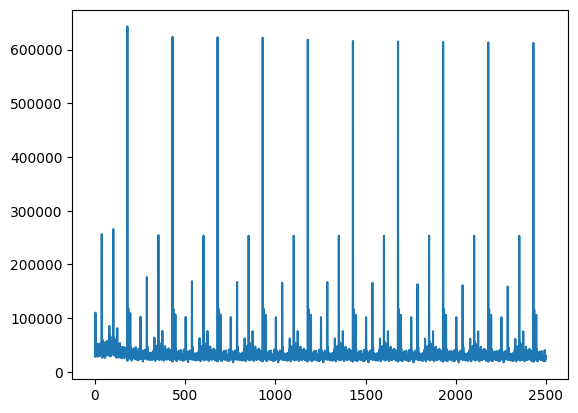

In [75]:
plt.plot(train_batch_losses)
#plt.ylim([15000,100000])

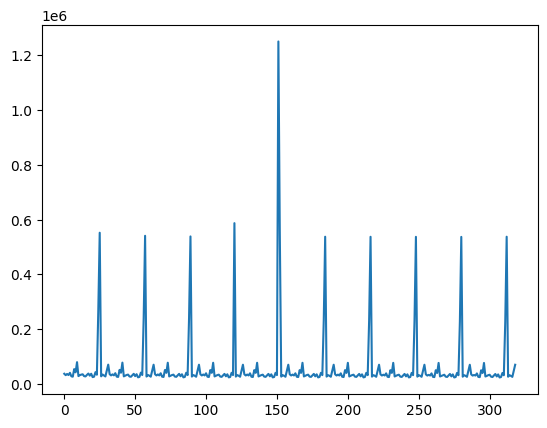

In [76]:
plt.plot(valid_batch_losses)
#plt.ylim([0,10])

In [19]:
model = VariationalAutoEncoder()
model.to(CFG.device)
criterion = F.mse_loss
#criterion = MSE#invdiceloss
optimizer = AdamW(params=model.parameters(),lr=1e-3)
checkpoint = torch.load('/kaggle/input/last-state/state_dict',map_location=torch.device(CFG.device))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [81]:
inp=next(iter(X_validloader)).permute(0,3,1,2).to(CFG.device)
out = model(train_normalize(inp[0:1]))[3].detach().to('cpu')

In [88]:
out1 = (out[0].permute(1,2,0)*X_train_std[0,0,0])+X_train_mean[0,0,0]

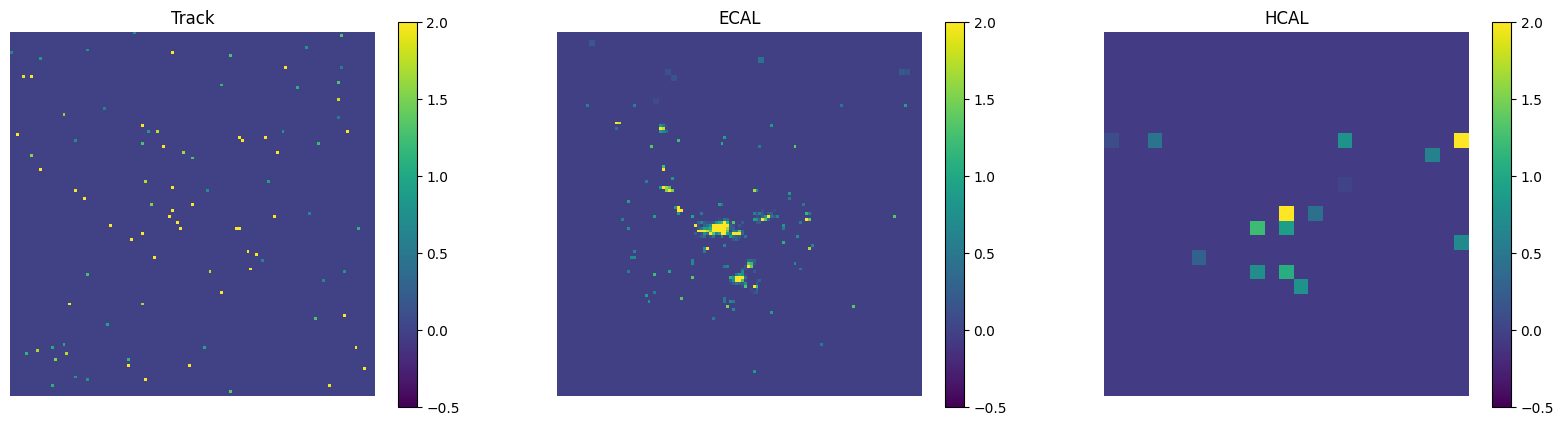

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
ls = ['Track','ECAL','HCAL']
for i in range(3):
    temp = axes[i].imshow(a[0,:,:,i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i].axis('off')
    axes[i].set_title('{}'.format(ls[i]))
    fig.colorbar(temp, ax=axes[i], shrink=0.25)

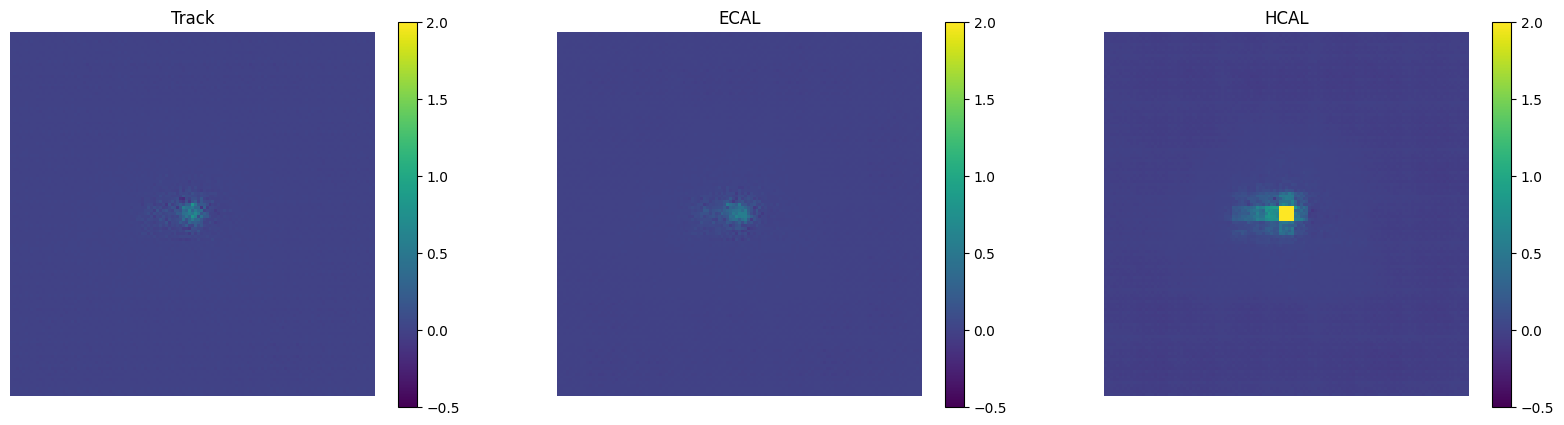

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
ls = ['Track','ECAL','HCAL']
for i in range(3):
    temp = axes[i].imshow(out[0,i,:,:], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i].axis('off')
    axes[i].set_title('{}'.format(ls[i]))
    fig.colorbar(temp, ax=axes[i], shrink=0.25)

# Discussion
The poor performance is due to sparsity in the jet images, it can be adressed using graph representation. \
Loss function used here is pixelwise loss+ KL divergence \
we can explore other loss functions like perceptual loss and for comparision we can use Cross Entropy and Inverse Dice Loss \